# Monk2
Grid Search for Monk2 dataset model selection


In [253]:
from exclusiveAI.components.Validation.HoldOut import parallel_hold_out, hold_out
from exclusiveAI.components.CallBacks import EarlyStoppingCallback
from exclusiveAI.ConfiguratorGen import ConfiguratorGen
from exclusiveAI.datasets.monk import read_monk2
from exclusiveAI.utils import one_hot_encoding
from exclusiveAI.Composer import Composer
from tqdm import tqdm
import pandas as pd
import numpy as np
from exclusiveAI.utils import plot_history
import os, json

#### Read Monk2 dataset 

In [254]:
training_data, training_labels, test_data, test_labels = read_monk2("../exclusiveAI/datasets/")

One-Hot Encoding Training Dataset

In [255]:
training_data = one_hot_encoding(training_data)

One-Hot Encoding Test Dataset

In [256]:
test_data = one_hot_encoding(test_data)

Getting the (most interesting) models from the big grid search 

In [257]:
def read_json_files(my_dir_path):
        data = pd.DataFrame()
        for file in os.listdir(my_dir_path):
            if file.endswith('.json'):
                with open(os.path.join(my_dir_path, file), 'r') as f:
                    my_data = [data['0'] for data in json.load(f).values()]
                    data = pd.concat([data,  pd.DataFrame(my_data)], ignore_index=True, axis=0)
        return data
batch_size = 100
epochs = 1000

final_file = "monk2_models_configs_hist.json"

if not os.path.exists(final_file):
    dir_path = "Monk2/"
    
    all_json_data = read_json_files(dir_path)
    # By knowledge of the dataset, being free of noise we should not need regularization
    # regularizations = all_json_data['regularization'].unique().tolist()
    regularizations = [0]
    learning_rates = all_json_data['learning_rate'].unique().tolist()
    learning_rates = set([round(value, 1) for value in learning_rates])
    # momentums = all_json_data['momentum'].unique().tolist()
    momentums = list(np.arange(0, 0.4, 0.1))
    # num_of_layers = all_json_data['num_layers'].unique().tolist()
    num_of_layers = [1]
    num_of_units = set([unit1 if unit1!=1 else 2 for unit in all_json_data['num_of_units'] for unit1 in unit])
    initializers = ["uniform", "gaussian"]
    activations = ["sigmoid"]
    
    # ea = EarlyStoppingCallback(patiente_limit=50, eps=)
    # 
    myConfigurator = ConfiguratorGen(random=False, learning_rates=learning_rates, regularizations=regularizations,
                                     loss_function=['mse'], optimizer=['sgd'],
                                     activation_functions=activations,
                                     number_of_units=num_of_units, number_of_layers=num_of_layers,
                                     momentums=momentums, initializers=initializers,
                                     input_shapes=training_data.shape,
                                     verbose=False, nesterov=True,
                                     callbacks=["earlystopping"], output_activation='sigmoid', show_line=False,
                                     ).get_configs()
    len(myConfigurator)
    
    configs=[]
    if __name__ == '__main__':
        configs.append(
            parallel_hold_out(myConfigurator, training=training_data, training_target=training_labels, epochs=epochs,
                              batch_size=batch_size, num_models=100, workers=8, number_of_initializations=3, return_models_history=True,
                              ))
    
        configs = pd.DataFrame(configs)
        # Save as json
        configs.to_json(final_file)
else: 
    with open(final_file, 'r') as f:
        configs = [data['0'] for data in json.load(f).values()]

In [258]:
models = []
old_histories = configs[0]
configs=configs[1]
with tqdm(total=len(configs)) as pbar:
    for old_hist, config in zip(old_histories, configs):
        model = Composer(config=config).compose()
        model.train(inputs=training_data, input_label=training_labels, epochs=epochs, batch_size=batch_size, name=config['model_name'], disable_line=True)
        test_val = model.evaluate(input=test_data, input_label=test_labels)
        models.append((model.get_last()['mse'], np.std(np.array(model.history['mse'])), model.get_last()['binary_accuracy'], test_val[0], test_val[1], model.curr_epoch, old_hist['binary_accuracy'][-1],  old_hist['val_binary_accuracy'][-1], old_hist['mee'],  old_hist['val_mee'], model.history['mee'], Composer(config=config).compose(), config, config['num_layers'], config['num_of_units'], config['model_name']))
        pbar.update(1)

# Convert the list of tuples to a DataFrame with one column for each element in the tuple
df = pd.DataFrame(models, columns=['Score', 'History_Std', 'Accuracy', 'Test_Score', 'Test_Accuracy', 'Trained_Epochs', 'Old_Accuracy', 'Old_Accuracy_val', 'Old_History', 'Old_History_val', 'History', 'Model', 'Config', 'Num_Layers', 'Num_of_Units', 'Name'])

100%|██████████| 100/100 [00:24<00:00,  4.16it/s]


In [259]:
# Sort the DataFrame by the first element in the tuple (column 'Value')

df_sorted = df.sort_values(by=['Num_Layers', 'History_Std', 'Score', 'Test_Score'])
df_sorted = df_sorted[df_sorted['Accuracy'] >= 1]
df_sorted = df_sorted[df_sorted['Test_Accuracy'] >= 1]
# df_sorted = df_sorted[df_sorted['History_Std'] <= 0.08]
# df_sorted = df_sorted[df_sorted['Test_Score'] <= 0.01]
# df_sorted = df_sorted[df_sorted['Num_Layers'] <= 1]
# df_sorted['Num_of_Units'] = [value[0] for value in df_sorted['Num_of_Units']]
# df_sorted = df_sorted[df_sorted['Num_of_Units'] == 4]
histories = {row[0]: row[1] for row in df_sorted[['Name', 'History']].values}
old_histories = {row[0]: row[1] for row in df_sorted[['Name', 'Old_History']].values}
old_histories_val = {row[0]: row[1] for row in df_sorted[['Name', 'Old_History_val']].values}
df_sorted

,Score,History_Std,Accuracy,Test_Score,Test_Accuracy,Trained_Epochs,Old_Accuracy,Old_Accuracy_val,Old_History,Old_History_val,History,Model,Config,Num_Layers,Num_of_Units,Name
27,0.039232,0.056611,1.0,0.046060,1.0,1000,0.637037,0.558824,"[0.499928236, 0.4874047041, 0.4796234071, 0.47...","[0.4997832775, 0.4943347871, 0.4909585416, 0.4...","[0.500378, 0.49120253, 0.48339626, 0.47847012,...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0, 'learning_rate': 0.5, 'l...",1,[4],Model191
82,0.029039,0.065631,1.0,0.033938,1.0,1000,0.637037,0.558824,"[0.5113371611, 0.494209975, 0.4864939451, 0.47...","[0.5048822761, 0.4975386858, 0.4942293167, 0.4...","[0.49535465, 0.48810482, 0.48310903, 0.4790500...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0, 'learning_rate': 0.6, 'l...",1,[4],Model71
36,0.028369,0.066010,1.0,0.032447,1.0,1000,0.637037,0.558824,"[0.502066493, 0.4936229587, 0.4871544838, 0.48...","[0.500818193, 0.4971467257, 0.494335413, 0.492...","[0.4985847, 0.49268728, 0.4876728, 0.483554, 0...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0, 'learning_rate': 0.5, 'l...",1,[2],Model174
89,0.023161,0.068370,1.0,0.026716,1.0,1000,0.637037,0.558824,"[0.4973065555, 0.4904251695, 0.4831952155, 0.4...","[0.4988421798, 0.4958913326, 0.4927918911, 0.4...","[0.5044004, 0.4959195, 0.490262, 0.48548967, 0...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0, 'learning_rate': 0.7, 'l...",1,[2],Model198
90,0.022789,0.070977,1.0,0.026142,1.0,1000,0.637037,0.558824,"[0.4994289875, 0.4897370934, 0.4831994474, 0.4...","[0.4997266829, 0.4956142902, 0.4928398132, 0.4...","[0.49770364, 0.49080735, 0.48459584, 0.4808308...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0, 'learning_rate': 0.6, 'l...",1,[3],Model70
56,0.022534,0.071249,1.0,0.026046,1.0,1000,0.637037,0.558824,"[0.5344994068, 0.5206142664, 0.5075410008, 0.4...","[0.5105747581, 0.5047790408, 0.499386102, 0.49...","[0.49293414, 0.48731345, 0.48325697, 0.4805666...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0, 'learning_rate': 0.5, 'l...",1,[2],Model168
32,0.019381,0.075729,1.0,0.022684,1.0,1000,0.637037,0.558824,"[0.4792022705, 0.4773724675, 0.4740172327, 0.4...","[0.4842582047, 0.4835226536, 0.4820761383, 0.4...","[0.47655952, 0.47476557, 0.4740066, 0.47272027...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0, 'learning_rate': 0.6, 'l...",1,[3],Model49
40,0.010534,0.080331,1.0,0.012703,1.0,1000,0.637037,0.558824,"[0.4802033007, 0.4769529104, 0.4678115547, 0.4...","[0.4866273403, 0.4854815006, 0.4820650816, 0.4...","[0.47405577, 0.47234863, 0.47217202, 0.4720347...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0, 'learning_rate': 0.9, 'l...",1,[3],Model100
75,0.012261,0.082814,1.0,0.014406,1.0,1000,0.637037,0.558824,"[0.5083513856, 0.4941331744, 0.4838865995, 0.4...","[0.5035710931, 0.4973548353, 0.4928784072, 0.4...","[0.5067947, 0.49600676, 0.48802412, 0.48271433...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0, 'learning_rate': 0.5, 'l...",1,[4],Model188
15,0.010884,0.083654,1.0,0.012740,1.0,1000,0.637037,0.558824,"[0.4987514317, 0.4901898503, 0.4765950441, 0.4...","[0.499407053, 0.4956237674, 0.4896243513, 0.48...","[0.5054883, 0.4949302, 0.48678192, 0.48239633,...",<exclusiveAI.components.NeuralNetwork.NeuralNe...,"{'regularization': 0, 'learning_rate': 0.7, 'l...",1,[3],Model214


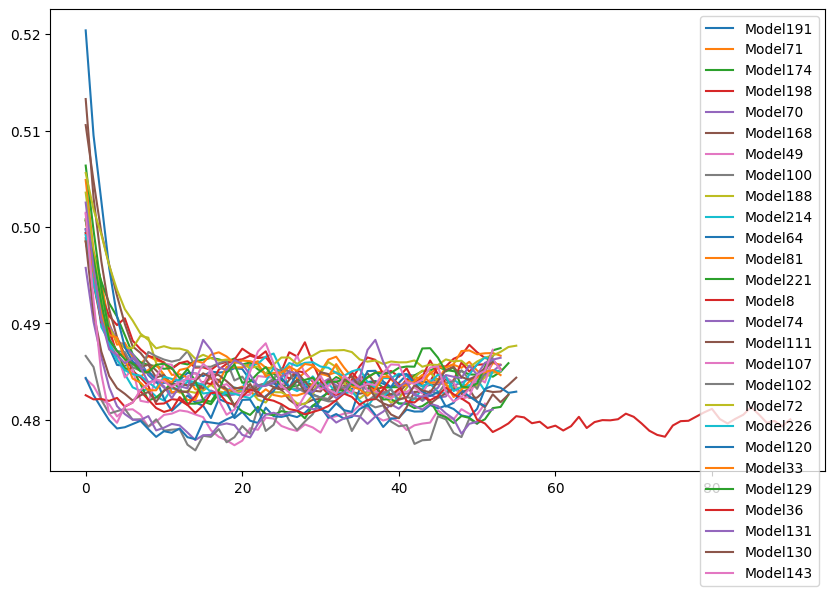

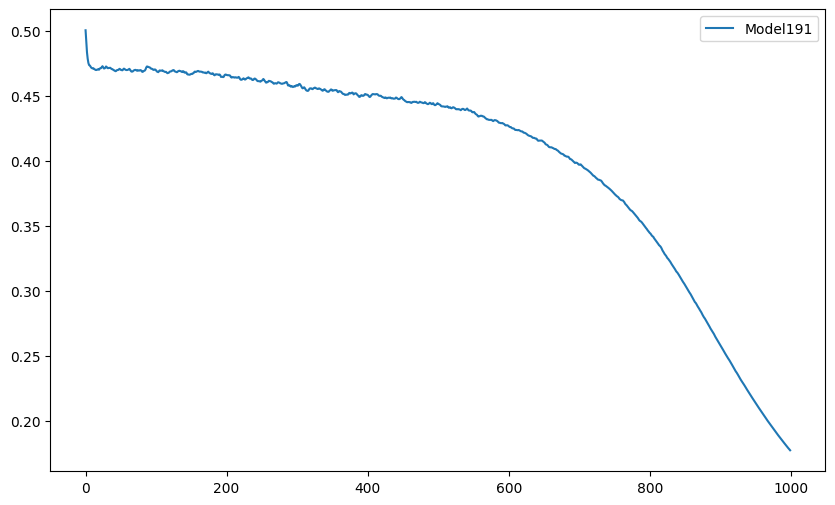

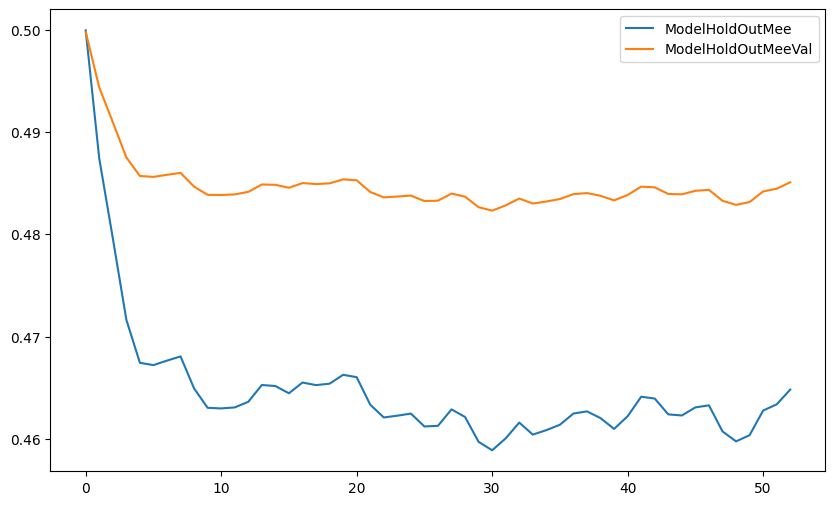

In [260]:
plot_history(old_histories_val)
plot_history({list(histories)[0]: list(histories.values())[0]})
plot_history({'ModelHoldOutMee': list(old_histories.values())[0], 'ModelHoldOutMeeVal': list(old_histories_val.values())[0]})
# plot_history({list(histories)[1]: list(histories.values())[1]})


Selected row:
Score                                                        0.005175
History_Std                                                  0.090524
Accuracy                                                          1.0
Test_Score                                                   0.005918
Test_Accuracy                                                     1.0
Trained_Epochs                                                   1000
Old_Accuracy                                                 0.637037
Old_Accuracy_val                                             0.558824
Old_History         [0.5413274169, 0.5146381259, 0.4969128668, 0.4...
Old_History_val     [0.51327461, 0.5030634403, 0.4964304566, 0.491...
History             [0.54066104, 0.5183883, 0.5000063, 0.48865196,...
Model               <exclusiveAI.components.NeuralNetwork.NeuralNe...
Config              {'regularization': 0, 'learning_rate': 0.9, 'l...
Num_Layers                                                          1
Num_of

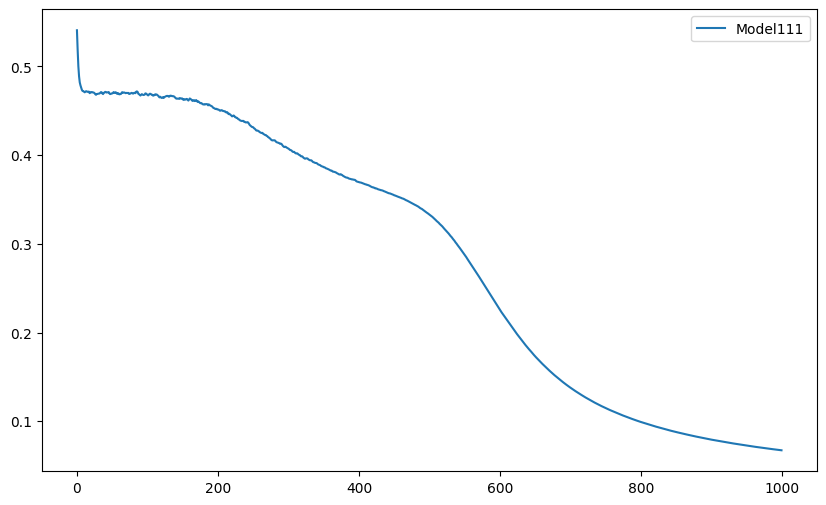

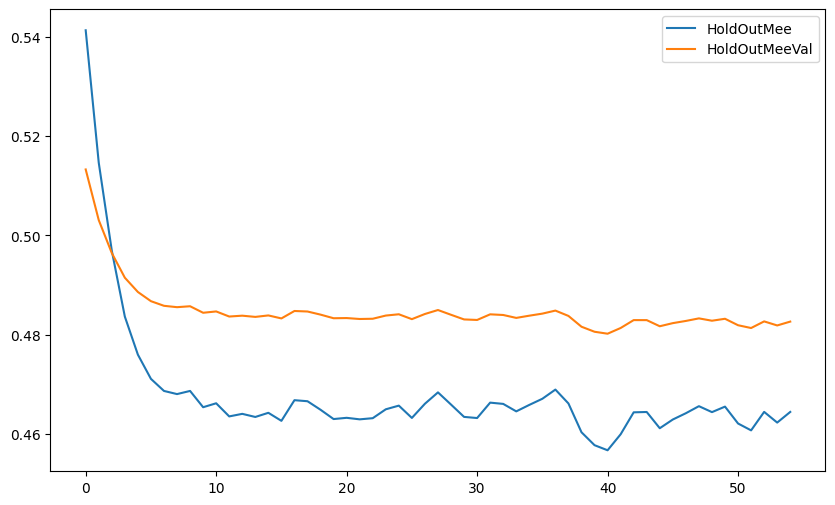

In [261]:
def find_least_difference_row(my_df):
    min_diff = float('inf')
    selected_row = None

    for index, row in my_df.iterrows():
        array = np.array(row['History'])
        differences =  (np.diff(array) / np.mean(array)) 
        min_consecutive_difference = np.min(differences)

        if min_consecutive_difference < min_diff:
            min_diff = min_consecutive_difference
            selected_row = row

    return selected_row

# Example usage:
result_row = find_least_difference_row(df_sorted)
print("Selected row:")
print(result_row)
plot_history({result_row["Name"]: result_row['History']})
plot_history({'HoldOutMee': result_row['Old_History'], 'HoldOutMeeVal': result_row['Old_History_val']})